# EFTfitter.jl - Advanced Tutorial

In [1]:
using EFTfitter
using BAT           # for sampling
using IntervalSets  # for specifying the prior
using Distributions # for specifying the prior
using Plots         # for plotting

---
It is recommended to store the inputs (i.e. parameters, observables, measurements and correlations)
and the actual analysis in two separate files. This allows to simply load different configurations
of the model. We will therefore also consider two files: `advanced_tutorial_inputs.jl` and `runAdvancedTutorial.jl`.

## File "advanced_tutorial_inputs.jl"

### Parameters
We use the same parameters & priors as in the basic tutorial:

In [2]:
parameters = BAT.NamedTupleDist(
    C1 = -3..3, # short for: Uniform(-3, 3)
    C2 = Normal(0, 0.5) # Normal distribution
)

ValueShapes.NamedTupleDist{(:C1, :C2),Tuple{Distributions.Uniform{Float64},Distributions.Normal{Float64}},Tuple{ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}},ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}}}}(
_internal_distributions: (C1 = Distributions.Uniform{Float64}(a=-3.0, b=3.0), C2 = Distributions.Normal{Float64}(μ=0.0, σ=0.5))
_internal_shape: ValueShapes.NamedTupleShape{(:C1, :C2),Tuple{ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}},ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}}}}((C1 = ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}}(ValueShapes.ScalarShape{Real}(), 0, 1), C2 = ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}}(ValueShapes.ScalarShape{Real}(), 1, 1)), 2)
)


### Observables
We use the same observables as in the basic tutorial. However, we use a different
way for creating the vector of functions for the MeasurementDistribution.

In [3]:
function xsec1(params)
    coeffs = [20.12, 5.56, 325.556]
    return myfunc(params, coeffs)
end

function xsec2(params)
    coeffs = [2.12, 4.3, 12.6]
    return myfunc(params, coeffs)
end

function myfunc(params, c)
    return c[1] * params.C1 + c[2] * params.C1 * params.C2+ c[3] * params.C2
end

myfunc (generic function with 1 method)

When using distributions of measurements, a vector of functions with the predictions
for the observable needs to be passed containing a function for each of the bins which
have only the model parameters as their argument. Defining a separate function for each
bin can, however, become tedious for a large number of bins, especially since typically
the bins of a distribution have a similar functional dependence on the model parameters
and only differ in some coefficients. In such cases, it is possible to use Julia's
[metaprogramming](https://docs.julialang.org/en/v1/manual/metaprogramming/) features to
create the vector of functions. The distribution in our [basic tutorial](https://tudo-physik-e4.github.io/EFTfitter.jl/dev/tutorial/)
has been defined by implementing three functions that all call the same function `myfunc`
but with different values for the coefficients
The same result can also be achieved like this:

In [4]:
function get_coeffs(i) # return the coefficients for bin i
    coeffs = [[2.2, 5.5, 6.6], [2.2, 5.5, 6.6], [2.2, 5.5, 6.6]]
    return coeffs[i]
end

function my_dist_func(params, i)
    coeffs = get_coeffs(i)
    return coeffs[1] * params.C1 + coeffs[2] * params.C1 * params.C2+ coeffs[3] * params.C2
end

my_dist_func (generic function with 1 method)

create an array of Functions with names `diff_xsec_binX`:

In [5]:
diff_xsec=Function[]
for i in 1:3
    @eval begin
        function $(Symbol("diff_xsec_bin$i"))(params)
            return my_dist_func(params, $i)
        end
        push!(diff_xsec, $(Symbol("diff_xsec_bin$i")))
    end
end

### Measurements
Information about the uncertainties of measurements need to be provided to EFTfitter.jl
in terms of the uncertainty values and corresponding correlation matrices.
If you have these information in terms of covariance matrices, you need to convert it
to correlation matrices and uncertainty values before. The function
[`cov_to_cor`](https://tudo-physik-e4.github.io/EFTfitter.jl/dev/api/#EFTfitter.cov_to_cor-Tuple{Array{var%22#s58%22,2}%20where%20var%22#s58%22%3C:Real})
can be used for this:

In [6]:
cov_syst = [3.24   0.81   0.378  0.324  0.468;
            0.81   0.81   0.126  0.162  0.234;
            0.378  0.126  0.49   0.126  0.182;
            0.324  0.162  0.126  0.81   0.234;
            0.468  0.234  0.182  0.234  1.69]

cor_syst, unc_syst = cov_to_cor(cov_syst)

([1.0 0.5 … 0.19999999999999998 0.19999999999999998; 0.5 1.0 … 0.19999999999999998 0.19999999999999998; … ; 0.19999999999999998 0.19999999999999998 … 1.0 0.19999999999999998; 0.19999999999999998 0.19999999999999998 … 0.19999999999999998 1.0], [1.8, 0.9, 0.7, 0.9, 1.3])

In [7]:
measurements = (

    Meas1 = Measurement(xsec1, 21.6,
            uncertainties = (stat=0.8, syst=unc_syst[1], another_unc=2.3)),

    Meas2 = Measurement(Observable(xsec2, min=0), 1.9,
            uncertainties = (stat=0.6, syst=unc_syst[2], another_unc=1.1), active=true),


    MeasDist = MeasurementDistribution(diff_xsec, [1.9, 2.93, 4.4],
                uncertainties = (stat = [0.7, 1.1, 1.2], syst= unc_syst[3:5], another_unc = [1.0, 1.2, 1.9]),
                active=[true, false, true]),
)

(Meas1 = EFTfitter.Measurement(EFTfitter.Observable(Main.##410.xsec1, -Inf, Inf), 21.6, (stat = 0.8, syst = 1.8, another_unc = 2.3), true), Meas2 = EFTfitter.Measurement(EFTfitter.Observable(Main.##410.xsec2, 0.0, Inf), 1.9, (stat = 0.6, syst = 0.9, another_unc = 1.1), true), MeasDist = EFTfitter.MeasurementDistribution(EFTfitter.Observable[EFTfitter.Observable(Main.##410.diff_xsec_bin1, -Inf, Inf), EFTfitter.Observable(Main.##410.diff_xsec_bin2, -Inf, Inf), EFTfitter.Observable(Main.##410.diff_xsec_bin3, -Inf, Inf)], [1.9, 2.93, 4.4], (stat = [0.7, 1.1, 1.2], syst = [0.7, 0.9, 1.3], another_unc = [1.0, 1.2, 1.9]), Bool[1, 0, 1], [:bin1, :bin2, :bin3]))

### Correlations
The correlations are again the same as in the basic tutorial.

In [8]:
dist_corr = [1.0 0.5 0.0;
             0.5 1.0 0.0;
             0.0 0.0 1.0]

another_corr_matrix = to_correlation_matrix(measurements,
    (:Meas1, :Meas2, 0.4),
    (:Meas1, :MeasDist, 0.1),
    (:MeasDist, :MeasDist, dist_corr),
    (:MeasDist_bin2, :MeasDist_bin3, 0.3),
)

5×5 Array{Float64,2}:
 1.0  0.4  0.1  0.1  0.1
 0.4  1.0  0.0  0.0  0.0
 0.1  0.0  1.0  0.5  0.0
 0.1  0.0  0.5  1.0  0.3
 0.1  0.0  0.0  0.3  1.0

In [9]:
correlations = (
    stat = NoCorrelation(active=true), # will use the identity matrix of the correct size

    syst = Correlation([1.0 0.5 0.3 0.2 0.2;
                        0.5 1.0 0.2 0.2 0.2;
                        0.3 0.2 1.0 0.2 0.2;
                        0.2 0.2 0.2 1.0 0.2;
                        0.2 0.2 0.2 0.2 1.0], active=true), # `active = false`: ignore all uncertainty values and correlations for this type of uncertainty

    another_unc = Correlation(another_corr_matrix, active=true)
)

(stat = EFTfitter.NoCorrelation
  active: Bool true
, syst = EFTfitter.Correlation([1.0 0.5 … 0.2 0.2; 0.5 1.0 … 0.2 0.2; … ; 0.2 0.2 … 1.0 0.2; 0.2 0.2 … 0.2 1.0], true), another_unc = EFTfitter.Correlation([1.0 0.4 … 0.1 0.1; 0.4 1.0 … 0.0 0.0; … ; 0.1 0.0 … 1.0 0.3; 0.1 0.0 … 0.3 1.0], true))

### Nuisance Correlations
When performing an analysis with unknown correlation coefficients, it is possible
to treat them as nuisance parameters in the fit.
For this, we define a further `NamedTuple` consisting of `NuisanceCorrelation` objects:

In [10]:
nuisance_correlations = (
    ρ1  = NuisanceCorrelation(:syst, :Meas1, :Meas2, -1..1),
    ρ2  = NuisanceCorrelation(:syst, :MeasDist_bin1, :MeasDist_bin3, truncated(Normal(0.5, 0.1), -1, 1)),
)

(ρ1 = EFTfitter.NuisanceCorrelation(:syst, :Meas1, :Meas2, Distributions.Uniform{Float64}(a=-1.0, b=1.0)), ρ2 = EFTfitter.NuisanceCorrelation(:syst, :MeasDist_bin1, :MeasDist_bin3, Truncated(Distributions.Normal{Float64}(μ=0.5, σ=0.1), range=(-1.0, 1.0))))

In the `NuisanceCorrelation` object we specify the name of the uncertainty type, the
names of the two measurements we want to correlate using the nuisance correlations and
a prior for the nuisance parameter. Note that the nuisance parameters should only be
varied in the interval (-1, 1) as they represent correlation coefficients.
For `ρ1` we choose a flat prior between -1 and 1. For `ρ2` we have some expectations and
formulate them using a Gaussian prior with μ=0.5 and σ=0.1. However, to ensure that `ρ2`
is only varied in the allowed region of (-1, 1), we [truncate](https://juliastats.org/Distributions.jl/stable/truncate/#Distributions.truncated)
the normal distribution accordingly.

## File "runAdvancedTutorial.jl"

We need to modify the definition of the `EFTfitterModel` by also passing the `nuisance_correlations`:

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm BAT.PriorSubstitution()
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:174
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 3 tuned, 4 converged.
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC T

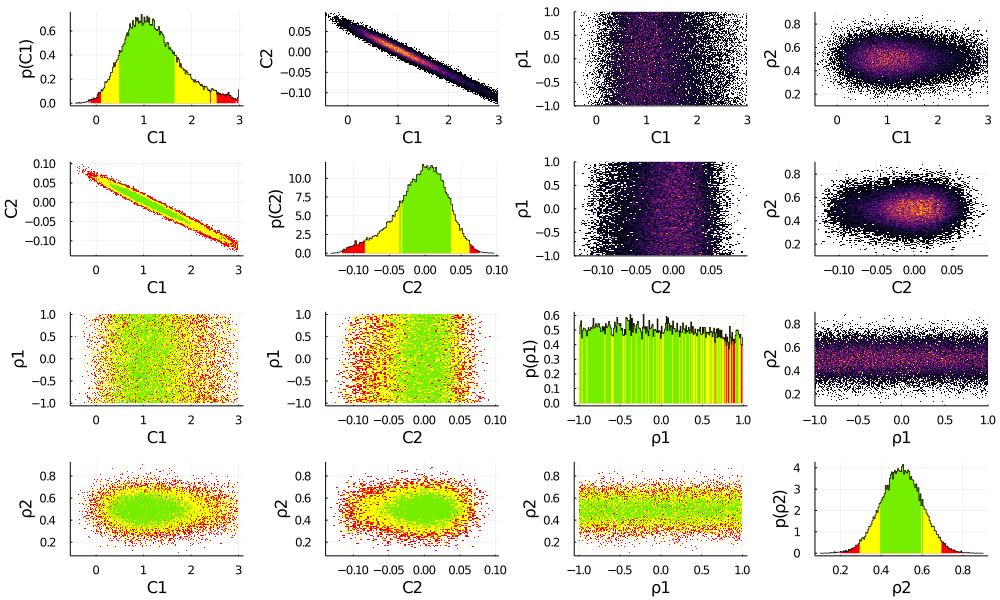

In [11]:
model = EFTfitterModel(parameters, measurements, correlations, nuisance_correlations)

posterior = PosteriorMeasure(model)

algorithm = MCMCSampling(mcalg = MetropolisHastings(), nsteps = 10^5, nchains = 4)
samples = bat_sample(posterior, algorithm).result;

p = plot(samples)

Warning:
When using nuisance correlations, it may happen that the fit does not converge anymore.
This happens mainly when the correlation values are close to -1 or +1.
In such a case, you can try to reduce the allowed ranges in the priors for the Nuisance
correlations to investigate at which values this happens.

### Ranking of measurements and uncertainties
With the `rank_measurements` and `rank_uncertainties` functions, the influence of
the individual measurements or uncertainty types on the result of a fit can be estimated.
For the ranking, each active measurement (respectively uncertainty type) is deactivated
at a time and the fit is repeated. The results of the fits with a deactivated
measurement (or uncertainty type) are then compared to the fit result with all measurements (uncertainty types) activated.
A ranking is calculated based on a ranking criterion calculated from the posterior distributions of these fits.

The default ranking criterion is the relative increase of the total width of the
smallest interval containing 90% of the posterior probability when deactivating a measurement.
For models with more than one parameter, the sum of the relative increases of all
one-dimensional smallest intervals is used, i.e. `SumOfSmallestIntervals(p=0.9, bins=200)`.

In [12]:
measurement_ranking = EFTfitter.rank_measurements(model)

┌ Info: Begin ranking of measurements
└ @ EFTfitter /home/cornelius/Projects/julia/EFTfitter.jl/src/ranking/ranking.jl:123
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm BAT.PriorSubstitution()
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:174
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 3 

EFTfitter.MeasurementRanks([:Meas1, :MeasDist_bin1, :Meas2, :MeasDist_bin3], [2.7570704834362316, 0.47045521036775545, 0.34062653274475296, -0.11294862772695285], EFTfitter.SumOfSmallestIntervals{Int64}
  p: Float64 0.9
  bins: Int64 200
)

The sampling algorithm to be used can be passed with the keyword `sampling_algorithm`.
By default, `BAT.MCMCSampling()` is used, i.e. Metropolis-Hastings with 4 chains and 100000 steps.

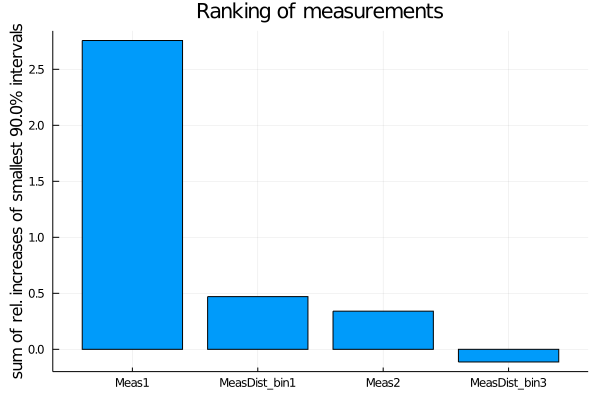

In [13]:
plot(measurement_ranking, title = "Ranking of measurements")

For ranking the uncertainty types, the relative decrease is used.

┌ Info: Begin ranking of uncertainties
└ @ EFTfitter /home/cornelius/Projects/julia/EFTfitter.jl/src/ranking/ranking.jl:164
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm BAT.PriorSubstitution()
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm BAT.PriorSubstitution()
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm BAT.PriorSubstitution()
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Initializing new RNG of type

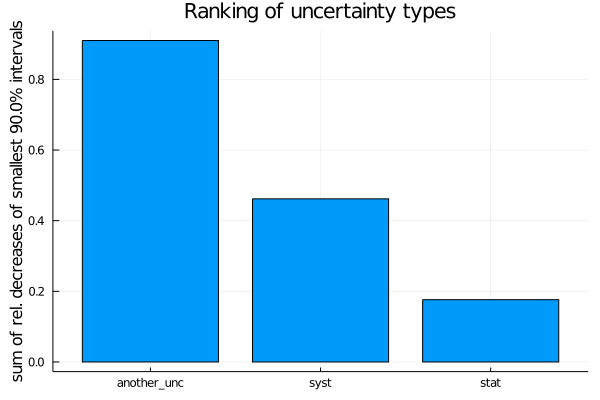

In [14]:
uncertainty_ranking = EFTfitter.rank_uncertainties(model,
    criterion = SumOfSmallestIntervals(p=0.9, bins=200),
    sampling_algorithm = SobolSampler(nsamples = 10^5), order = :values)

plot(uncertainty_ranking, title = "Ranking of uncertainty types")

Please see the [ranking documentation](https://tudo-physik-e4.github.io/EFTfitter.jl/dev/api/#EFTfitter.rank_measurements) for further ranking criteria and keyword arguments.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*